In [131]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [132]:
data_path='data/TSF-TSFlex-KDynamic22.csv'
#trade_sheet='ThaiNov22-Now23'
trade_sheet='THAIRally21'
noFee=True


start_date='2020-10-01'
end_date='2022-03-31'



fee_sheet='Fee'
# data_path=r'D:\PythonDev\MyQuantFinProject\Data\thai_fund.csv'
trade_plan_path='data/Config-BuySellTrade.xlsx'

# excludeFund=['ASP-T12','KKP-TQG']
excludeFund=[]


file_name=trade_sheet
if noFee==True:
 report_path=f'report/{file_name}(no-fee).xlsx'
else:
 report_path=f'report/{file_name}.xlsx' 
print(report_path)
# trade_sheet='BuySell_Buy_Hold'
# report_path=f'report/BuySell_4ETFFunds.xlsx'





report/THAIRally21(no-fee).xlsx


# Read Price CSV

In [133]:
df=pd.read_csv(data_path,parse_dates=['Date/Time'],dayfirst=True)
df.columns=['symbol','date','price']
df=df.query('date>=@start_date and date<=@end_date')
df.info()
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 2867 to 11684
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  1089 non-null   object        
 1   date    1089 non-null   datetime64[ns]
 2   price   1089 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 34.0+ KB
           symbol       date  price
11462  TISCOFLEXP 2021-05-06  56.24
11684  TISCOFLEXP 2022-03-31  62.36
6360        TSF-A 2021-08-26  81.17
6439        TSF-A 2021-12-22  83.60
11582  TISCOFLEXP 2021-11-02  60.41
6211        TSF-A 2021-01-12  68.41
11343  TISCOFLEXP 2020-11-03  38.78
6339        TSF-A 2021-07-23  79.50
6306        TSF-A 2021-06-08  78.83
11660  TISCOFLEXP 2022-02-25  62.08


# List Symbol and Plot Chart

In [134]:
list_symbols=list(df['symbol'].unique())
list_symbols=[ f for f in list_symbols if f not in excludeFund ]
list_symbols
# list_symbols=['ACWI']


['KFDYNAMIC', 'TSF-A', 'TISCOFLEXP']

['KFDYNAMIC', 'TSF-A', 'TISCOFLEXP']
==============================KFDYNAMIC==============================


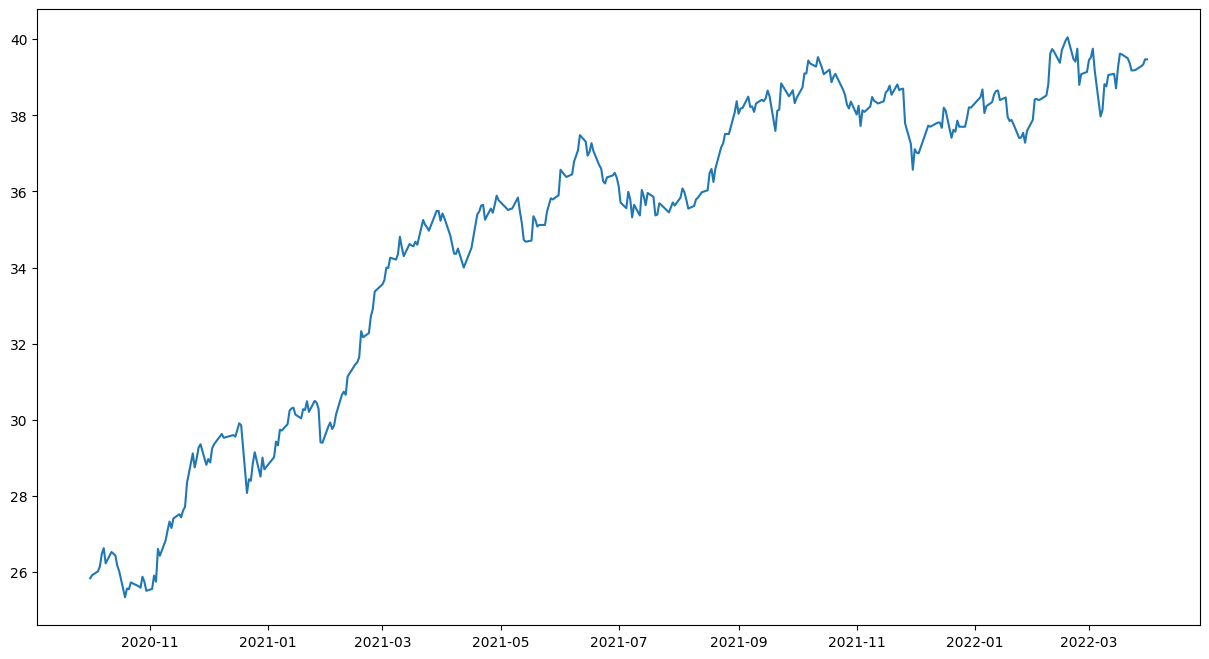

==============================TSF-A==============================


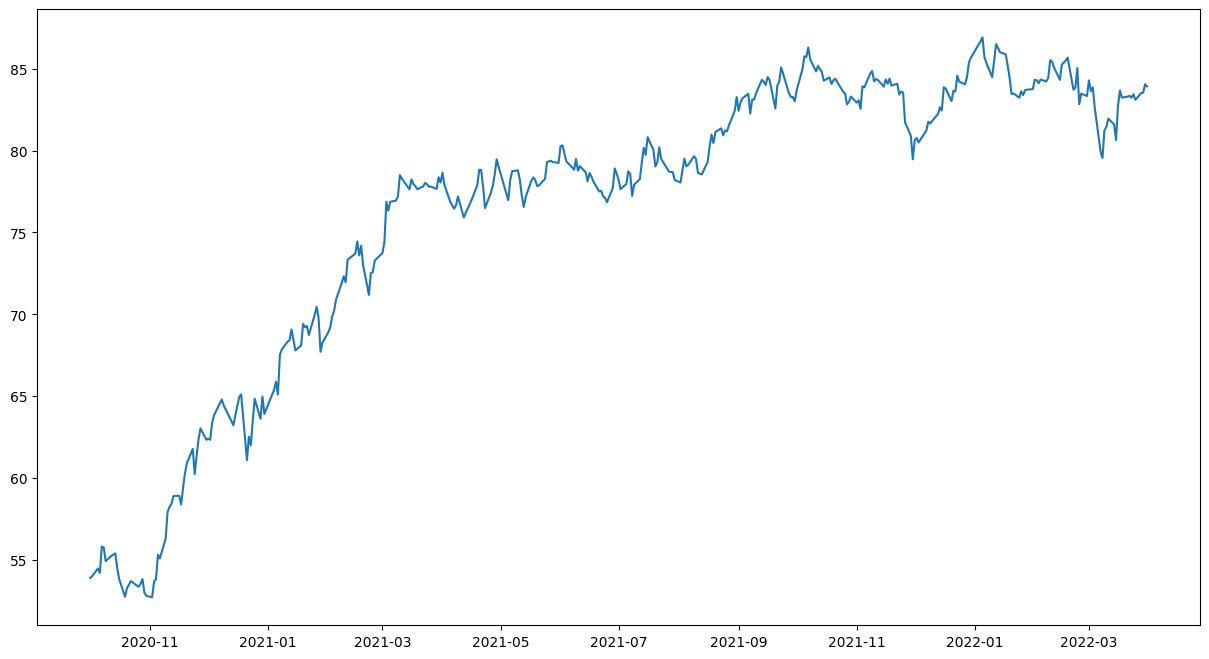

==============================TISCOFLEXP==============================


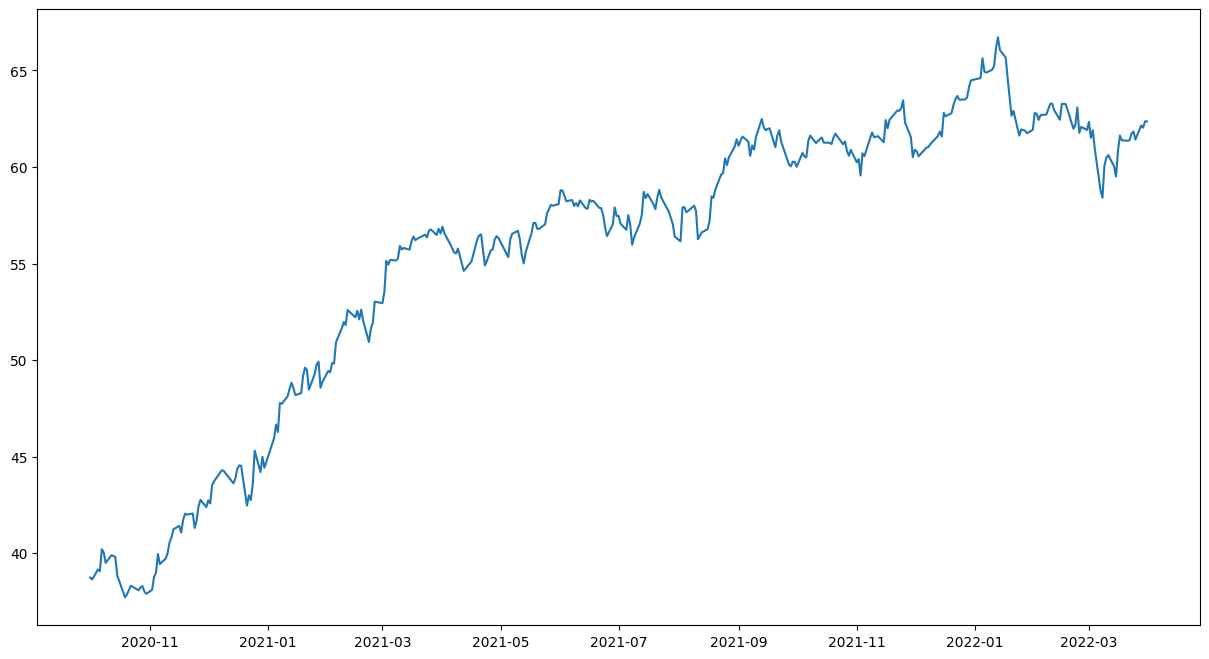

In [135]:
print(list_symbols)
for  symbol in list_symbols:
    print(f"=============================={symbol}==============================")
    dfFund=df.query('symbol==@symbol')
    plt.figure(figsize=(15, 8))
    plt.plot(dfFund['date'],dfFund['price'])
    plt.show()

# Get Trade Data and Fee

In [136]:
# read feeon 
dfAssetInfo=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name=fee_sheet,\
                    index_col='symbol', dtype ={'buy_fee_pct': np.float64,'sell_fee_pct': np.float64})

# check where  fund fee  in portfolio  are avaible?
dfNoFeeInfo= [ item for item in list_symbols if item not in list(dfAssetInfo.index)]
dfAssetInfo=dfAssetInfo.loc[list(list_symbols),:]

if noFee==True:
    dfAssetInfo[['buy_fee_pct','sell_fee_pct']]=0
    
print("fee info")
print(dfAssetInfo) 
# For instance   AAXJ Price=100 but we need to pay 101 $

fee info
            buy_fee_pct  sell_fee_pct  region
symbol                                       
KFDYNAMIC             0             0     NaN
TSF-A                 0             0     NaN
TISCOFLEXP            0             0     NaN


In [137]:
dfPlan=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name=trade_sheet, \
                     parse_dates=['trade_date'],dtype ={'portion_pct': np.float64})

#total buy portion is equal or greater than sell portion
buy_sum_act=dfPlan.query("action=='b'").portion_pct.sum()
sell_sum_act=dfPlan.query("action=='s'").portion_pct.sum()

all_portion=0

In [138]:
if buy_sum_act<sell_sum_act:
  raise Exception("Not allow Buy <= Sell")   
else:
    if buy_sum_act>sell_sum_act:
       print("=============Calculate the last portion to be sellable")
       sellAllAtNow=buy_sum_act-sell_sum_act 
       dfLastPrice=pd.DataFrame(columns=list(dfPlan.columns), data=[ [df['date'].max(),sellAllAtNow,'s']])
       print(dfLastPrice)
       dfPlan=pd.concat([dfPlan,dfLastPrice])
       dfPlan=dfPlan.reset_index(drop=True)

    tradeDateList= [ d for d in list(dfPlan['trade_date']) ]    
    all_portion=buy_sum_act   
    print(f"portion = {all_portion} on")
    
print("==========================Summarize All Trade==========================================")
print(f"No Buy/Sell {dfPlan.groupby(['action']).size()}")
print(dfPlan)

portion = 100.0 on
==========================Summarize All Trade==========================================
No Buy/Sell action
b    4
s    3
dtype: int64
  trade_date  portion_pct action
0 2020-11-25         25.0      b
1 2020-12-30         25.0      b
2 2021-01-15         25.0      b
3 2021-02-05         25.0      b
4 2021-11-01         50.0      s
5 2021-12-01         25.0      s
6 2022-02-01         25.0      s


In [139]:
# To make it easier for use to understand portfolio transatoin 
TotalBudget=100*1000
rrr=TotalBudget % all_portion
if rrr !=0 :
  raise Exception(f"Your Budget {TotalBudget} is  not proportional  Portion with {all_portion}")
else:
  print(f"Your Budget {TotalBudget} is  proportional  Portion with {all_portion}")

Your Budget 100000 is  proportional  Portion with 100.0


# Custom Function

In [140]:
# figure out the amount of qty from total fund total value
def get_qty_buy(item):
    xCost=(item['portion_pct']/all_portion)*TotalBudget  
    xPrice=item['price_on_fee']
    qty=xCost/xPrice
    return qty

# figure the amount of  qty out  from total qty
def get_qty_sell(item,TotalQty):  
    qty=(item['portion_pct']/all_portion)*TotalQty
    return qty

In [141]:
def set_fee_by_action(item):
  x=item['symbol']  
  if item['action']=='b':
    fee_type='buy_fee_pct'
  elif  item['action']=='s':
    fee_type='sell_fee_pct'
  try:
     return dfAssetInfo.loc[x,fee_type]
  except Exception as ex:
     print(f"Error : no {x} to get fund fee")
     return 0

In [142]:
dict_dfTran={}
dfSummary=pd.DataFrame(columns=['Symbol','BuyValue','AvgBuyPrice','SellValue','AvgSellPrice','PL','Percent_PL'])

dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL


In [143]:
#https://www.w3resource.com/pandas/dataframe/dataframe-apply.php

for symbol in list_symbols:
    print(f"*******************{symbol}*******************")

    dfBS=df[ (df['symbol']==symbol) & (df['date'].isin(tradeDateList))]
    # if len(tradeDateList)==len(dfBS):
        
     # Step1  join price data (filter by sybom and the date whiich you have buy/sell action)   
    dfBS=dfBS.merge(dfPlan,how='inner',left_on='date',right_on='trade_date')
     # remove  redundant data  
    dfBS=dfBS.drop(columns=['trade_date'])     
       
    
     # Step2 calculate fee function
    dfBS['fee']=dfBS.apply(set_fee_by_action,axis=1) # 2.1
    
     # The price that allows you to buy the fund is more expensive than the actual asset price  1%  ,other the other had 
     # Buy price*1.0x=??   
    dfBS['price_on_fee']=dfBS.apply(lambda item : item['price']*(1+ (item['fee']/100)) if item['action']=='b' else item['price']*(1-(item['fee']/100)), axis=1)
    dfBS['price_on_fee']=dfBS['price_on_fee'].round(2) #2.2   
    # print(dfBS)
        
     # Step3  To make it easier to calculate and trading sumary in tearm of qty both buy/sell , both use different way
     # we recommend spliting this dataframe  into 2 dataframe
     #  BuyDataFrame and Sell Date , and we will merge both later  
    
    #3.1 query only buy action
    print("======================Buy=======================")
    buyDF=dfBS.query("action=='b'")   
    
    # 3.2 send the  row to function to calculate qty 
    buyDF['qty']=buyDF.apply(get_qty_buy,axis=1) 
    buyDF['value']=round(buyDF['qty']*buyDF['price_on_fee'],0)
    
    
    # 1 is buy (I will take columne to apply cumsum function to calcaulate cumulative return
    buyDF['action_value']=buyDF['value']
    buyDF['action_qty']=buyDF['qty']
    
    # 3.3 Total qty and value and avg
    TotalQty=buyDF['qty'].sum()
    TotalValue=round(buyDF['value'].sum(),0)
    AvgPrice=round(TotalValue/TotalQty,2)
    
    # print(buyDF[['date','portion_pct','value' ,'price','fee','price_on_fee','qty']])
    
    
    # Step4 follow every step corresponidng to prev step#3
    print("=======================Sell=======================")
    # step#4.1
    sellDF=dfBS.query("action=='s'")  
    
    # ste#4.2
    sellDF['qty']=sellDF.apply(get_qty_sell,axis=1,args=(TotalQty,))
    sellDF['value']=round(sellDF['qty']*sellDF['price_on_fee'],0)
    
    # -1 is sell (I will take columne to apply cumsum function to calcaulate cumulative return
    sellDF['action_value']=sellDF['value']*-1
    sellDF['action_qty']=sellDF['qty']*-1
    
    # print(sellDF[['date' ,'portion_pct','value','price','fee','price_on_fee','qty']])
    

    
    print("======================Merge Buy & Sell======================")
    # step 5  concatenate buy and sell dataframe 
    dfTran=pd.concat([buyDF,sellDF],axis=0)
    dfTran=dfTran.sort_values(by=['date'])
    dfTran[['value','action_value']]=dfTran[['value','action_value']].round(0)

    # step 6 accumulate value and qury over entire data since start buying to last record 
    dfTran['net_value']=dfTran['action_value'].cumsum(axis = 0) 
    dfTran['net_qty']=dfTran['action_qty'].cumsum(axis = 0)  
    dfTran['avg_price']=round( dfTran['net_value']/dfTran['net_qty'],2)
    
    dfTran=dfTran.sort_values(by=['date'])
    # print(dfTran[['date' ,'action','price_on_fee','qty','net_qty','value','net_value','avg_price']])
    print(dfTran[['date' ,'action','price_on_fee','qty','value','avg_price']])
    
    dict_dfTran[symbol]=dfTran
    
    print("=======================Summarize Gain/Loss=======================")
    #step 7 create total buy/sell value , avg prie and profit/loss(value and %) of  all funds 
    # step 7.1 apply sum agg over  value and qty to find avg throughout  the whold dataframe
    SellTotalQty=sellDF['qty'].sum()
    SellTotalValue=round(sellDF['value'].sum(),0)
    SellAvgPrice=round(SellTotalValue/SellTotalQty,0)
    
    print(f"Total Buy {symbol} : qty={TotalQty} and value={TotalValue} at AvgPrice={AvgPrice}")
    print(f"Total Sell {symbol} : qty={SellTotalQty} and value={SellTotalValue} at AvgPrice={SellAvgPrice}")
    

    
    # step #7.2
    PL=round(SellTotalValue-TotalValue,0)
    PCT_PL=round(PL/TotalValue*100,2)
    
    # step# 7.3 
    # you take amont 100000.0 and gain profit103500 from investment on this etf fund 
    summary_data={'Symbol':symbol,'BuyValue':TotalValue,'AvgBuyPrice':AvgPrice,'SellValue':SellTotalValue,\
                  'AvgSellPrice':SellAvgPrice, 'PL':PL,'Percent_PL':PCT_PL
                 }
    dfSummary=dfSummary.append(summary_data,ignore_index=True)
    
    print(dfSummary)

    


*******************KFDYNAMIC*******************
======================Buy=======================
=======================Sell=======================
======================Merge Buy & Sell======================
        date action  price_on_fee          qty    value  avg_price
0 2020-11-25      b         28.98   862.663906  25000.0      28.98
1 2020-12-30      b         28.70   871.080139  25000.0      28.84
2 2021-01-15      b         30.14   829.462508  25000.0      29.26
3 2021-02-05      b         30.14   829.462508  25000.0      29.48
4 2021-11-01      s         38.02  1696.334531  64495.0      20.93
5 2021-12-01      s         37.11   848.167266  31475.0       4.75
6 2022-02-01      s         38.42   848.167266  32587.0       -inf
=======================Summarize Gain/Loss=======================
Total Buy KFDYNAMIC : qty=3392.6690621042394 and value=100000.0 at AvgPrice=29.48
Total Sell KFDYNAMIC : qty=3392.6690621042394 and value=128557.0 at AvgPrice=38.0
      Symbol  BuyValue  A

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_14104\186035005.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['qty']=buyDF.apply(get_qty_buy,axis=1)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_14104\186035005.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['value']=round(buyDF['qty']*buyDF['price_on_fee'],0)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_14104\186035005.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [144]:
dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL
0,KFDYNAMIC,100000.0,29.48,128557.0,38.0,28557.0,28.56
1,TSF-A,100000.0,65.80,125700.0,83.0,25700.0,25.70
2,TISCOFLEXP,100000.0,46.04,132586.0,61.0,32586.0,32.59


In [145]:
dfPort=dfSummary[['BuyValue','SellValue','PL']].sum().to_frame('All Funds')
dfPort=dfPort.T
dfPort['PercentPL']=round( (dfPort['PL']/dfPort['BuyValue'] *100) ,0)
dfPort

,BuyValue,SellValue,PL,PercentPL
All Funds,300000.0,386843.0,86843.0,29.0


In [146]:
writer=pd.ExcelWriter(report_path,engine='xlsxwriter') 

dfPort.to_excel(writer,sheet_name='TotalPort',index=False)

dfSummary=dfSummary.sort_values(by=['Percent_PL'],ascending=False)
dfSummary.to_excel(writer, sheet_name="Summary",index=False)

for symbol,tranDF in dict_dfTran.items():
 tranDF=tranDF.drop(columns=['symbol'])   
 tranDF.to_excel(writer, sheet_name=symbol,index=False) 
writer.save()

writer.close()

print("Successfully")

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_14104\886247830.py:11: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Successfully


D:\ProgramData\Anaconda3\envs\google_base\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
